# Health Insurance Dataset (by Alexey Bobko)

### Task:
- Build a model that predicts "charges" for a given person based on their features.
- Evaluate the quality of your model.
- Identify the factors with the highest impact.


In [798]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [829]:
import warnings
warnings.filterwarnings('ignore')

In [801]:
# load data
df_insurance = pd.read_csv("./insurance.csv")
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Call info() method to view data information.<br> We can see that there is no NaN, so we don't need to fill in empty cells.

Body Mass Index (BMI):<br>
    I = $\frac{m}{h^2}$  <br>
    
    where 
   - m - weight in kg, 
   - h - height in m

## Data visualization

Visualize data to understand what it is.

First, look at the BMI values

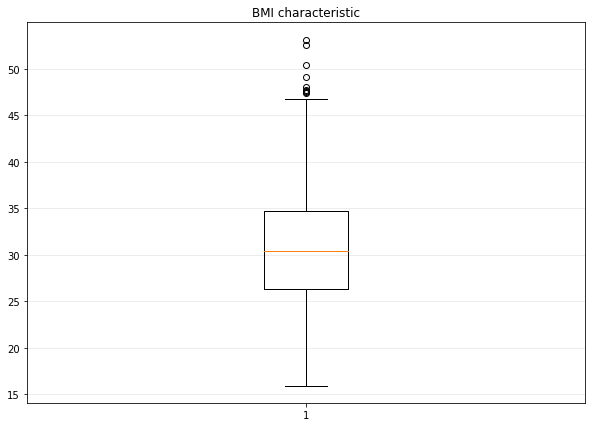

In [763]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title("BMI characteristic")
ax.yaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
ax.boxplot(df_insurance.bmi)

plt.show()

Then we output how many people live in every region

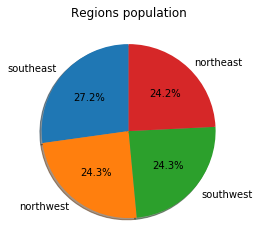

In [764]:
fig, ax = plt.subplots()

regions_names = df_insurance.region.value_counts().index
region_population = df_insurance.region.value_counts().values

ax.set_title("Regions population")
ax.pie(region_population, labels=regions_names, 
         autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

And look at sex and smookers division

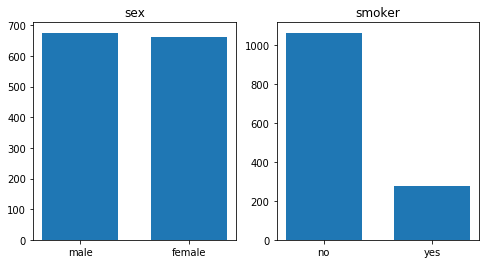

In [765]:
fig, (ax_sex, ax_smoker) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax_sex.set_title("sex")
ax_smoker.set_title("smoker")

sex_names = df_insurance.sex.value_counts().index
sex_cnt = df_insurance.sex.value_counts().values

smoke_answers = df_insurance.smoker.value_counts().index
smokers_cnt = df_insurance.smoker.value_counts().values

ax_sex.bar(sex_names, sex_cnt, width=0.7)
ax_smoker.bar(smoke_answers, smokers_cnt, width=0.7)
plt.show()

Let's analyze what ages groups there are

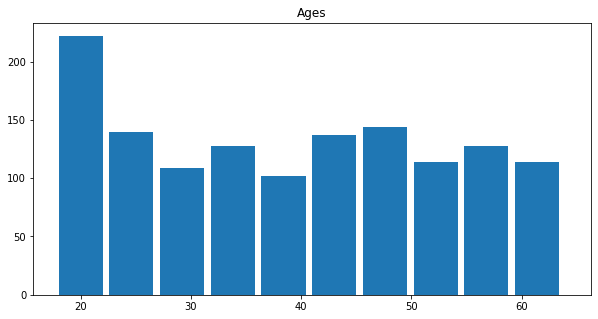

In [766]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df_insurance.age, width=4)
ax.set_title("Ages")
plt.show()

And also look at number of children

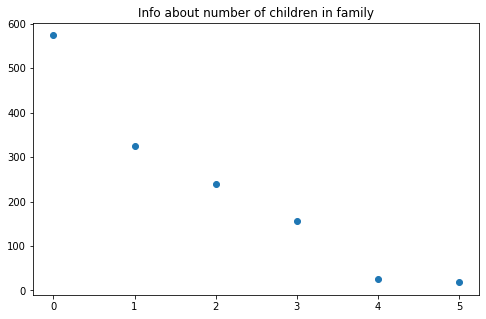

In [767]:
fig, ax = plt.subplots(figsize=(8, 5))

has_children = df_insurance.children.value_counts().index
children_cnt = df_insurance.children.value_counts().values
ax.set_title("Info about number of children in family")
ax.plot(has_children, children_cnt, 'o')
plt.show()

Depending on the charges and ages there are interesting dependencies

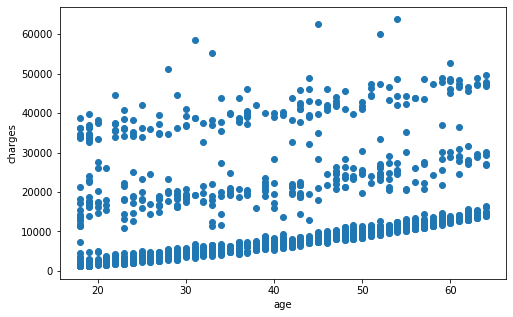

In [805]:
fig, ax = plt.subplots(figsize=(8, 5))

age = df_insurance.age
charges = df_insurance.charges
ax.set_xlabel("age")
ax.set_ylabel("charges")
ax.scatter(age, charges)
plt.show()

# Data preprocessing

Before we build a model, we need to process the data (scale it, change categorical features on numerical). We create special classes to preprocess data

In [811]:
class SexEncoder:
    # 0 - male
    # 1 - female

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_result = X.copy()
        X_result.loc[X_result.sex == "male", "sex"] = 0
        X_result.loc[X_result.sex == "female", "sex"] = 1
        
        return X_result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [812]:
class SmokerEncoder:
    # 0 - no
    # 1 - yes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_result = X.copy()
        X_result.loc[X_result.smoker == "yes", "smoker"] = 1
        X_result.loc[X_result.smoker == "no", "smoker"] = 0
        
        return X_result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

There are two ways how to encode region. The first idea is change regions on cardinal directions (southwest on south and west). The second idea is encode regions by labels

In [813]:
class DirectionEncoder:    
    def encode_regions(self, X):
        # encode region data
        сardinal_directions = ["north", "south", "west", "east"]
        has_direction = {}
        for direction in сardinal_directions:
            has_direction[direction] = np.array(X.region.map(
                    lambda region: 1 if (direction in region) else 0
                ))

        df_directions_info = pd.DataFrame(has_direction)
        return df_directions_info
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_result = X.copy()
        df_directions_info = self.encode_regions(X_result)
        X_result = pd.concat([X_result.reset_index(drop=True), 
                              df_directions_info.reset_index(drop=True)
                             ], 
                             axis=1)        
        # charges_col = X_result.pop("charges")
        # X_result["charges"] = charges_col
        X_result = X_result.drop(["region"], axis=1)        
        return X_result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [809]:
class RegionEncoder:     
    def __init__(self):
        self.encoder = LabelEncoder()
        
    def fit(self, X, y=None):        
        self.encoder.fit(X[['region']])
        return self

    def transform(self, X):
        X_result = X.copy()
        X_result['region'] = self.encoder.transform(X_result[['region']])        
        return X_result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [814]:
class DataScaler:
    def __init__(self, scaler, cols):
        self.scaler = scaler
        self.cols = cols
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.cols], y)
        return self

    def transform(self, X):
        X_result = X.copy()
        X_result[self.cols] = self.scaler.transform(X_result[self.cols])
        return X_result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

## Create and score model

Split our dataset on train and test subsets

In [848]:
X = df_insurance.drop(["charges"], axis=1)
y = df_insurance.charges
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Create pipeline for our data processing.

In [849]:
steps = [('sex_en', SexEncoder()), 
         ('smoker_en', SmokerEncoder()),          
         ('dir_en', DirectionEncoder()),
         # ('region_en', RegionEncoder()),
         ('scaler', DataScaler(MinMaxScaler(), ['age', 'bmi', 'children'])),
         ('poly', PolynomialFeatures(degree=2))
        ]
preproc_pipe = Pipeline(steps)

In [850]:
steps = [('preprocessor', Pipeline(steps)), 
         ('estimator', Lasso(alpha=24))]
pipe = Pipeline(steps)

Find the best alpha to our Lasso regression using GridSearch

In [851]:
X_train_preproc = preproc_pipe.fit_transform(X_train)

In [852]:
parameters = {'alpha': list(range(100))}
gs_pipe = GridSearchCV(Lasso(), parameters)

In [853]:
gs_pipe.fit(X_train_preproc, y_train)
gs_pipe.best_params_

{'alpha': 24}

Score our model using cross validation

In [854]:
score = cross_val_score(pipe, X, y, cv=5)
score

array([0.85850687, 0.79715564, 0.88101499, 0.81936415, 0.83741596])

Calculate mean score

In [855]:
np.mean(score)

0.8386915213726203

Now find parameters of the highest impact

In [856]:
X_train_preproc = preproc_pipe.fit_transform(X_train)

In [857]:
pipe.steps[1][1].fit(X_train_preproc, y_train)

Lasso(alpha=24, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

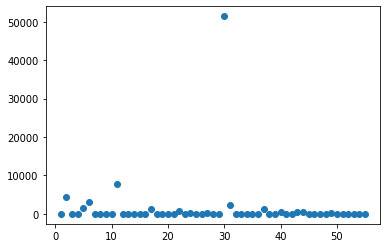

In [861]:
plt.scatter(range(1, len(pipe.steps[1][1].coef_) + 1), pipe.steps[1][1].coef_)

There are 5-6 the most impact parameters. Let's look at them

In [864]:
# all coefs
pipe.steps[1][1].coef_

array([ 0.00000000e+00,  4.25015451e+03,  0.00000000e+00,  0.00000000e+00,
        1.50824735e+03,  2.98593252e+03,  0.00000000e+00, -0.00000000e+00,
       -1.71236631e+01,  4.98158691e-13,  7.66742224e+03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.24713703e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.68256975e+02, -0.00000000e+00,  2.00078964e+02,
       -0.00000000e+00, -0.00000000e+00,  1.46998865e+02, -0.00000000e+00,
        0.00000000e+00,  5.14495802e+04,  2.22210617e+03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.18395786e+03,  0.00000000e+00,  0.00000000e+00,  4.97577844e+02,
        4.04639033e+01, -0.00000000e+00,  3.63589618e+02,  3.56638839e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.77040315e+02, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -4.08758792e+01,  

In [885]:
indexes_of_max_coefs = np.argsort(pipe.steps[1][1].coef_)[-7:]
indexes_of_max_coefs

array([16,  4, 30,  5,  1, 10, 29], dtype=int64)

In [888]:
for index in indexes_of_max_coefs:
    print("{0} - {1}".format(
            pipe.steps[0][1].steps[-1][1].powers_[index],
            pipe.steps[1][1].coef_[index]
        )
    )
    
# ['age', 'sex', 'bmi', 'children', 'smoker', "north", "south", "west", "east"]

[1 0 0 0 0 0 1 0 0] - 1247.1370335105569
[0 0 0 1 0 0 0 0 0] - 1508.2473458298693
[0 0 1 0 0 1 0 0 0] - 2222.106173745796
[0 0 0 0 1 0 0 0 0] - 2985.932518428969
[1 0 0 0 0 0 0 0 0] - 4250.154513019187
[2 0 0 0 0 0 0 0 0] - 7667.422238857684
[0 0 1 0 1 0 0 0 0] - 51449.58022650834


#### Conclusion:
We can see that the highest impact parameters are age, bmi and smoker columns. 